# Projected Variational Quantum Dynamics

The projected Variational Quantum Dynamics (p-VQD) algorithm is a quantum algorithm for real time evolution. It's a variational algorithm that projects the state at time $t + \Delta_t$, as calculated with Trotterization, onto a parameterized quantum circuit. 

For a quantum state $|\phi(\theta)\rangle = U(\theta)|0\rangle$ constructed by a parameterized quantum circuit $U(\theta)$ and a Hamiltonian $H$, the update rule can be written as

$$
\theta_{n+1} = \arg\min_{\delta\theta} 1 - |\langle\phi(\theta + \delta\theta)|e^{-i\Delta_t H}|\phi(\theta)\rangle|^2,
$$

where $e^{-i\Delta_t H}$ is calculated with a Trotter expansion (using e.g. the `PauliEvolutionGate` in Qiskit!).

The following tutorial explores the p-VQD algorithm in Qiskit, which is implemented available as `PVQD` in

In [145]:
from qiskit.algorithms import VarQRTE, VarQITE
from qiskit.algorithms.evolvers.variational import RealMcLachlanPrinciple, ImaginaryMcLachlanPrinciple

Here are the necessary imports for this tutorial.

In [93]:
import numpy as np
import scipy as sc

from qiskit import BasicAer
from qiskit.algorithms.evolvers import EvolutionProblem
from qiskit.algorithms.optimizers import SPSA, L_BFGS_B, GradientDescent, COBYLA
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.opflow import X, Z, I, MatrixExpectation, Gradient, PauliExpectation
from qiskit.quantum_info import Statevector

import matplotlib.pyplot as plt

The example we're looking at is the time evolution of the $|00\rangle$ state under the Hamiltonian

$$
    H = 0.1 Z_1 Z_2 + X_1 + X_2,
$$

which is an Ising Hamiltonian on two neighboring spins, up to a time $T=1$ and we want to keep track of the total magnetization $M = Z_1 Z_2$.

In [183]:
final_time = 3
# hamiltonian = 0.1 * (Z ^ Z) + (I ^ X) + (X ^ I)
# observable = Z ^ Z
hamiltonian = (X ^ I) + (I ^ X)

Next, we need to choose the parameterized ansatz we project the update steps onto. We have different choices here, but for real time evolution an ansatz that contains building blocks of the evolved Hamiltonian usually performs very well.

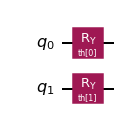

In [197]:
theta = ParameterVector("th", 5)
ansatz = QuantumCircuit(2)
ansatz.ry(theta[0], 0)
ansatz.ry(theta[1], 1)
# ansatz.rzz(theta[2], 0, 1)
# ansatz.rx(theta[3], 0)
# ansatz.rx(theta[4], 1)

# you can try different circuits, like:
# from qiskit.circuit.library import EfficientSU2
# ansatz = EfficientSU2(2, reps=1)

ansatz.draw("mpl", style="iqx")

With this ansatz, the $|00\rangle$ state is prepared if all parameters are 0. Hence we'll set the initial parameters to $\theta_0 = 0$:

In [198]:
initial_parameters = np.zeros(ansatz.num_parameters)

Before running we need to select the backend and how we want to calculate the expectation values. Here, we'll use exact statevector simulations (which is still very fast as we investigate a 2 qubit system).

In [199]:
backend = BasicAer.get_backend("qasm_simulator")
expectation = PauliExpectation()

Since p-VQD performs a classical optimization in each timestep to determine the best parameters for the projection, we also have to specify the classical optimizer. As a first example we're using BFGS, which typically works well in statevector simulations, but later we can switch to gradient descent.

In [200]:
bfgs = L_BFGS_B()

Now we can define p-VQD and execute it!

In [201]:
from qiskit.algorithms.optimizers import COBYLA

def lse_solver(A, b):
    return COBYLA().minimize(lambda x: x.T.dot(A).dot(x) - 2 * b.T.dot(x) + 0.01 * np.dot(x, x), x0=np.zeros_like(b)).x

In [202]:
principle = ImaginaryMcLachlanPrinciple()
qte = VarQITE(principle, lse_solver=lse_solver, expectation=expectation, quantum_instance=backend)

The p-VQD implementation follows Qiskit's time evolution interface, thus we pack all information of the evolution problem into an input class:

In [203]:
problem = EvolutionProblem(hamiltonian, time=final_time, param_value_dict=dict(zip(ansatz.parameters, initial_parameters)), 
                           aux_operators=[hamiltonian, observable], initial_state=ansatz)

And then run the algorithm!

In [204]:
result = qte.evolve(problem)

Now we can have a look at the results, which are stored in a `PVQDResult` object. This class has the fields

* `evolved_state`: The quantum circuit with the parameters at the final evolution time.
* `times`: The timesteps of the time integration. At these times we have the parameter values and evaluated the observables.
* `parameters`: The parameter values at each timestep.
* `observables`: The observable values at each timestep.
* `fidelities`: The fidelity of projecting the Trotter timestep onto the variational form at each timestep.
* `estimated_error`: The estimated error as product of all fidelities.

The energy should be constant in a real time evolution. However, we are projecting the time-evolved state onto a variational form which might violate this rule. Ideally the energy is still more or less constant. In this evolution here we observe shifts of ~10% of the energy.

In [205]:
print(result)

{   'aux_ops_evaluated': [   (-2.0, 0.0),
                             (-0.017578124999999833, 0.03124517165076589)],
    'evolved_state': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f7e00113940>}


In [206]:
print(result.evolved_state)

      ┌──────────────────────┐
q_0: ─┤ Ry(-1.5638830795574) ├
     ┌┴──────────────────────┤
q_1: ┤ Ry(-1.56757227938677) ├
     └───────────────────────┘


Since we also kept track of the total magnetization of the system, we can plot that quantity too. However let's first compute exact reference values to verify our algorithm results.

In [207]:
result.aux_ops_evaluated[0][0]

-2.0

In [208]:
np.linalg.eigh(hamiltonian.to_matrix())

(array([-2.00000000e+00, -4.51028104e-17,  0.00000000e+00,  2.00000000e+00]),
 array([[-5.00000000e-01+0.j, -7.07106781e-01+0.j,  0.00000000e+00+0.j,
          5.00000000e-01+0.j],
        [ 5.00000000e-01+0.j,  2.45326947e-17+0.j, -7.07106781e-01+0.j,
          5.00000000e-01+0.j],
        [ 5.00000000e-01+0.j,  2.45326947e-17+0.j,  7.07106781e-01+0.j,
          5.00000000e-01+0.j],
        [-5.00000000e-01+0.j,  7.07106781e-01+0.j,  0.00000000e+00+0.j,
          5.00000000e-01+0.j]]))

In [139]:
def exact(final_time, timestep, hamiltonian, initial_state):
    """Get the exact values for energy and the observable."""
    observable = (Z ^ hamiltonian.num_qubits).to_matrix()
    H = hamiltonian.to_matrix()
    
    energ, magn = [], []  # list of energies and magnetizations evaluated at timesteps timestep
    times = []  # list of timepoints at which energy/obs are evaluated
    time = 0
    while time <= final_time:
        # get exact state at time t
        exact_state = initial_state.evolve(sc.linalg.expm(-1j * time * H))
        # store observables and time
        times.append(time)
        energ.append(exact_state.expectation_value(H))
        magn.append(exact_state.expectation_value(observable))

        # next timestep
        time += timestep

    return times, energ, magn

In [140]:
initial_state = Statevector(ansatz.bind_parameters(initial_parameters))
exact_times, _, exact_magnetizations = exact(final_time, 0.01, hamiltonian, initial_state)

Text(0.5, 1.0, 'Magnetization over time')

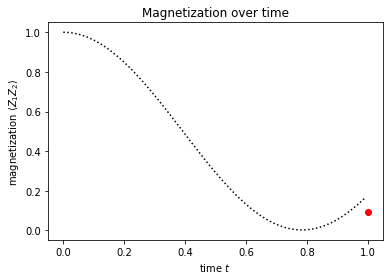

In [141]:
# magnetizations = np.real(result.observables)[:, 1]

# plt.plot(result.times, magnetizations, color="crimson")
plt.plot(final_time, result.aux_ops_evaluated[1][0], "ro")
plt.plot(exact_times, exact_magnetizations, ":", color="k")
plt.xlabel("time $t$")
plt.ylabel(r"magnetization $\langle Z_1 Z_2 \rangle$")
plt.title("Magnetization over time")

Looks pretty good!

### Gradient-based optimizations

The `PVQD` class also implements parameter-shift gradients for the loss function and we can use a gradient descent optimization routine

$$
    \theta_{k+1} = \theta_{k} - \eta_k \nabla\ell(\theta_k).
$$

Here we're using a learning rate of 

$$
    \eta_k = 0.1 k^{-0.602}
$$
and 100 optimization steps in each timestep.

In [15]:
maxiter = 100
learning_rate = 0.1 * np.arange(1, maxiter + 1) ** (-0.602)
gd = GradientDescent(maxiter, lambda: iter(learning_rate))

In [16]:
pvqd.optimizer = gd

**Warning:** The following cell will run a few minutes.

In [17]:
result_gd = pvqd.evolve(problem)

Text(0.5, 1.0, 'Energy over time')

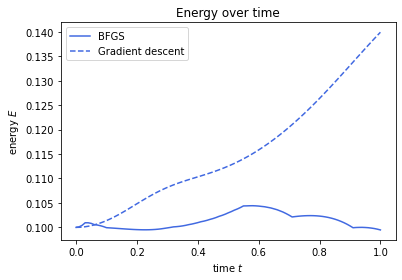

In [18]:
energies_gd = np.real(result_gd.observables)[:, 0]

plt.plot(result.times, energies, "-", color="royalblue", label="BFGS")
plt.plot(result_gd.times, energies_gd, "--", color="royalblue", label="Gradient descent")
plt.legend(loc="best")
plt.xlabel("time $t$")
plt.ylabel("energy $E$")
plt.title("Energy over time")

We can observe here, that the energy does vary quite a lot! But as we mentioned before, p-VQD does not preserve the energy.

Text(0.5, 1.0, 'Magnetization over time')

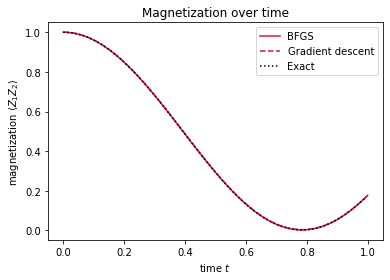

In [19]:
magnetizations_gd = np.real(result_gd.observables)[:, 1]

plt.plot(result.times, magnetizations, "-", color="crimson", label="BFGS")
plt.plot(result_gd.times, magnetizations_gd, "--", color="crimson", label="Gradient descent")
plt.plot(exact_times, exact_magnetizations, ":", color="k", label="Exact")
plt.legend(loc="best")
plt.xlabel("time $t$")
plt.ylabel(r"magnetization $\langle Z_1 Z_2 \rangle$")
plt.title("Magnetization over time")

The magnetization, however, is computed very precisely.